In [ ]:
!pip install -Iv gym==0.17.1
!conda install piglet
!pip install pystan
!conda install swig
!pip install box2d-py
!pip install box2d-py
!pip install gym[box2d]
!pip3 install pybullet --upgrade # This step may take ~5 minutes

Using pip 21.1.3 from /usr/local/lib/python3.7/dist-packages/pip (python 3.7)
Value for scheme.platlib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.purelib does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/lib/python3.7/dist-packages
sysconfig: /usr/lib/python3.7/site-packages
Value for scheme.headers does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/include/python3.7/UNKNOWN
sysconfig: /usr/include/python3.7m/UNKNOWN
Value for scheme.scripts does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local/bin
sysconfig: /usr/bin
Value for scheme.data does not match. Please report this to <https://github.com/pypa/pip/issues/9617>
distutils: /usr/local
sysconfig: /usr
Additional context:
user = False
home

/bin/bash: conda: command not found
/bin/bash: conda: command not found


A2C-single-thread-continuous

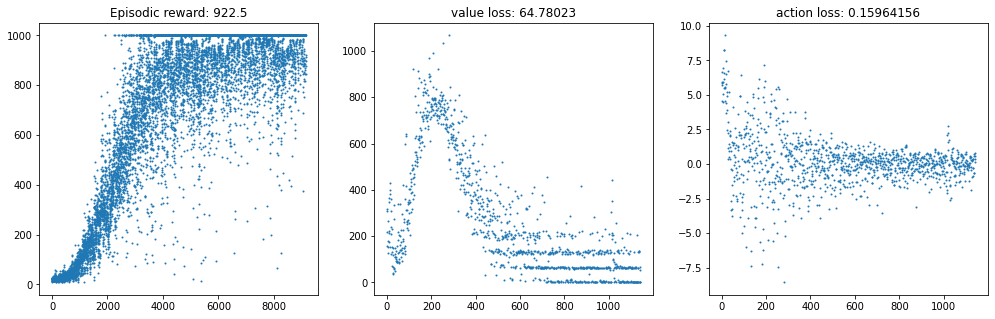

KeyboardInterrupt: ignored

In [ ]:
# Paste the .py code here
import torch
import torch.nn as nn
from torch.distributions import MultivariateNormal
import gym
import numpy as np
from IPython.display import clear_output
import matplotlib.pyplot as plt
import torch.nn.functional as F
import pybullet_envs

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

def plot(avg_rewards, value_losses, action_losses, log_interval):
    '''        For monitoring the training process    '''
    clear_output(True)
    # plt.figure(figsize=(7,7)) 
    # plt.title(' reward: %s' % (np.mean(avg_rewards[-10:])))
    # plt.plot(avg_rewards)
    # plt.show()

    
    plt.figure(figsize=(17,5))
    plt.subplot(1,3,1)
    plt.title('Episodic reward: %s' % (np.mean(avg_rewards[-log_interval:])))
    plt.scatter(np.linspace(0,len(avg_rewards)-1,len(avg_rewards)),avg_rewards, s=1)

    plt.subplot(1,3,2)
    plt.title('value loss: %s' % ( np.mean(value_losses[-log_interval:])))
    plt.scatter(np.linspace(0,len(value_losses)-1,len(value_losses)),value_losses, s=1)
    
    plt.subplot(1,3,3)
    plt.title('action loss: %s' % ( np.mean(action_losses[-log_interval:])))
    plt.scatter(np.linspace(0,len(action_losses)-1,len(action_losses)),action_losses, s=1)
    plt.show()




class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.next_states = []
        self.logprobs = []
        self.rewards = []
        self.dones = []
        self.bootstrapes = []
    
    def clear_memory(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.dones[:]
        del self.bootstrapes[:]
        del self.next_states[:]
        
    def insert(self, state,action,next_state,reward,done,bootstrap):
        self.states.append(state)
        self.actions.append(action)
        self.next_states.append(next_state)
        self.rewards.append(reward)
        self.dones.append(done)
        self.bootstrapes.append(bootstrap)
        

class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        '''To Do: Create an Actor network with 2 hidden layers.
                  Each hidden layer with 64 neurons and using PReLU() as activation.
                  The output of the network is the approximated value estimate for the state'''
        self.critic = nn.Sequential(
                nn.Linear(state_dim,64),
                nn.PReLU(),
                nn.Linear(64,64),
                nn.PReLU(),
                nn.Linear(64,1)
                )

    def forward(self):
        raise NotImplementedError
        
    def evaluate_state_value_no_gradient(self, state):
        with torch.no_grad():
            value = self.critic(state).detach()
        return value
    
    
    def evaluate_state_value(self, state):
        value = self.critic(state)            
        return value

    
    
class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.log_std_min = -5
        self.log_std_max = 2
        '''To Do: Create an Actor network with 2 hidden layers.
                  Each hidden layer with 64 neurons and using PReLU() as activation.
                  The output of the network should be:
                  (a) the mean for each action dimension :mu
                  (b) the variance for each action dimension :var  (must be positive, we cast it into a poistive number in def forward )
                  The output is therefore 2* action_dim    
        '''
        self.action_dim = action_dim
        self.base_block = nn.Sequential(
                nn.Linear(state_dim,64),
                nn.PReLU(),
                nn.Linear(64,64),
                nn.PReLU(),
                )
        self.mu_block = nn.Sequential(
                nn.Linear(64,action_dim),
                nn.Tanh()
                )
        self.var_fcn = nn.Linear(64,action_dim)

        
    def forward(self, state):
        ''' Input : state (Tensor)
            Return : mu and var (Tensor)
        '''
        mu = self.mu_block(self.base_block(state))
        log_var = self.var_fcn(self.base_block(state))
        # To do: Variance must be a positive number, therefore, Use F.softplus() to var to make it strictly positive
        log_var = F.softplus(log_var)#torch.clamp(log_var,self.log_std_min,self.log_std_max)
        var = torch.exp(log_var) # exponentiate  log_var
        return mu, var
        
    def act(self, state):
        ''' To Do:
            Refer to https://pytorch.org/docs/stable/distributions.html
            (1) first pass the state S to NN to get action_mean, and action_var
            (2) Create a torch.distributions.MultivariateNormal which takes the mean and variance, variance stays the same for all states.
            (3) sample an action according to the normal distribution in step 2 ,  torch.distributions.sample() , 
            Return action (in tensor), Note : .to(device) is required to make sure tensors are all on GPU or CPU.
            useful function: torch.diag_embed(), MultivariateNormal(), .sample() 
            Input : state  (Tensor, [1, state_dim])
            Return: action (Tensor, [1, action_dim])
        '''
        # print(state.size())
        with torch.no_grad():
            action_mean, action_var = self.forward(state)
        cov_mat = torch.diag_embed(action_var).to(device)
        # define the covaraince matrix from action_var, which is of shape [ 1, action_dim, action_dim] 
        dist = torch.distributions.MultivariateNormal(action_mean,cov_mat) 
        # initiate an instance of  multivariate Gaussian distribution
        action = dist.sample()
        # sample an action from dist, which is of shape [1, action_dim]
        
        return action.detach()

    def act_test(self, state):
        ''' For testing phase, we would like to have deterministic action 
            by taking the mean of the Gaussian Distribution.
            Return test_action (in tensor)
            Input : state  (Tensor, [1, state_dim])
            Return: action (Tensor, [1, action_dim])
        '''       
        with torch.no_grad():
            action_mean,_ = self.forward(state)
        return action_mean.detach()
    
    def evaluate(self, state, action):   
        ''' To Do: Compute the action_logprobs and entropy in batch mode (for all samples in memory)        
            Useful function in pytorch : torch.diag_embed(), distribution.log_prob(), distribution.entropy()  
            see https://pytorch.org/docs/stable/distributions.html            
            Input : state (Tensor, [#rollout, state_dim]), action (Tensor, [#rollout,action_dim])
            Return: action_logprobs (1-D tensor)--> torch.size([rollout]) , dist_entropy (1-D tensor)--> torch.size([rollout])
            The first dimension of cov_mat takes the form of an diagonalized matrix [action_dim_1_var, 0...
                                                0, action_dim_2_var, 0,...,
                                                ...
                                                0 ......, action_dim_N_var], 
            where off-diagonal elements are 0, assuming independence among each action dimension.
        ''' 
        action_mean, action_var = self.forward(state)        
        action_var = action_var.expand_as(action_mean).to(device)
        #3-D Tensor [#rollout, action_dim, action_dim] , where the action var is on
        cov_mat = torch.diag_embed(action_var).to(device)
        dist = torch.distributions.MultivariateNormal(action_mean,cov_mat)  
        if len(action.shape) == 1:
            action = action.unsqueeze(1)
        # Refer to : https://github.com/pranz24/pytorch-soft-actor-critic/issues/18 so that a correct gradient to Actor can be formulated. 
        # This is needed because we squash the action betwenn [-1,1], which is not the original action proposed by the network.
        # useful function : torch.log(), torch.tanh(),...
        action_logprobs = dist.log_prob(action) - torch.sum(torch.log(1-torch.tanh(action)**2),dim=1)

        dist_entropy = dist.entropy()
        return action_logprobs , dist_entropy



class A2C:
    def __init__(self, state_dim, action_dim, lr, betas, gamma):
        self.lr = lr
        self.betas = betas
        self.gamma = gamma
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)   
        self.optimizer_actor = torch.optim.Adam(self.actor.parameters(), lr=lr)
        self.optimizer_critic = torch.optim.Adam(self.critic.parameters(), lr=lr*5)
        self.MseLoss = nn.MSELoss()
    
    def select_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor.act(state).cpu().data.numpy().flatten()


    def select_test_action(self, state):
        state = torch.FloatTensor(state.reshape(1, -1)).to(device)
        return self.actor.act_test(state).cpu().data.numpy().flatten()
    
        
    
    def update(self, memory):
        '''This part is almost the same as A2C-single_thread-discrete.py. Here we do Advantage Actor-critic update'''
        # convert list to tensor
        states = np.array(memory.states)
        states = torch.FloatTensor(states).to(device)
        actions = np.array(memory.actions)
        actions = torch.squeeze(torch.FloatTensor(np.stack(actions)).to(device), 1)

        # --------------------compute value loss----------------
        # IMPORTANT: Compute the Monte-Carlo Returns as the update target for all V(S_t)        
        state_values = self.critic.evaluate_state_value(states)         
        
        # IMPORTANT: we will compute advantage based on the returns, the advantage we use here is the fourth formulae in Page 22 (the one with no bias and high variance) in http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-6.pdf.
        returns = [] # Target value for V(S_t), where Monte-Carlo returns are used.

        next_states = np.array(memory.next_states)
        next_states = torch.FloatTensor(next_states).to(device) 
        next_state_values = self.critic.evaluate_state_value_no_gradient(next_states).squeeze().cpu().numpy()
        # To Do: initialize the td_target with last element of next_state_values to allow for bootstrapping in case of pseudo termination(max episodic length reached)
        ct = -1
        td_target = next_state_values[ct]
        # ----------Start computing returns------------

        for reward, done, bootstrap in zip(reversed(memory.rewards), reversed(memory.dones), reversed(memory.bootstrapes)):
            # returns = [td_target(S_0),td_target(S_1)...,td_target(S_T-1), # for the first episode
            #            td_target(S_0),td_target(S_1)...,td_target(S_T-1), # for the second episode
            #            ,....,
            #            td_target(S_0),td_target(S_1)...,td_target(S_T-1), # for the last episode]
            # returns is computed in reversed order!! First compute td_target(S_T-1) from the last episode,
            # then to  td_target(S_T-2) from the last epi,....td(S_0) of the last epi, td(S_T-1) of the LAST SECOND epi, td(S_T-2).... until the first
            if done==True and bootstrap==False: # 
                td_target = 0 # To think
            elif bootstrap==True: # Pseudo termination due to max episodic length being reached
                td_target = next_state_values[ct] # to think,
            td_target = reward + td_target * self.gamma #.... a recursive form to compute the td_target as the return, 'td_target' should appear on the right part of the equation.
            # To do: Insert the td_target into the first element of the list 'returns', while maintaning the existing elements in the list.
            returns.insert(0,td_target)
            ct -= 1
            
        returns = torch.FloatTensor(returns).to(device)

        #------------------ update action loss---------------- 
        # To Do: compute advantages
        advantages = returns - state_values.detach()# TO do... ,as mentioned above we Monte Carlo returns to compute advantages, See http://rail.eecs.berkeley.edu/deeprlcourse/static/slides/lec-6.pdf ,       
        logprobs, dist_entropy = self.actor.evaluate(states, actions)        
        action_loss = torch.mean(-(advantages * logprobs))# To Do :  
        # Encourage the agent to explore by maximizing the entropy
        action_loss = action_loss - 0.01 * dist_entropy.mean() # TO think : plus the entropy or minus the entropy   0.01 * dist_entropy.mean() 
        self.optimizer_actor.zero_grad()
        action_loss.backward()
        self.optimizer_actor.step()       
        # print('value loss: {}, action loss: {}'.format(value_loss, action_loss))  
        
        #-----------Update value estimate-------------
        val_loss = nn.MSELoss() # To do 
        value_loss = val_loss(returns, state_values)
        self.optimizer_critic.zero_grad()
        value_loss.backward()
        self.optimizer_critic.step()
  
        
        return value_loss.cpu().data.numpy().flatten(), action_loss.cpu().data.numpy().flatten()


def main():
    ############## Hyperparameters ##############
    env_name = 'InvertedPendulumBulletEnv-v0'  
    # creating environment
    env = gym.make(env_name)
    env_test = gym.make(env_name)
    state_dim = env.observation_space.shape[0]
    action_dim = env.action_space.shape[0]
    render = False
    solved_reward = np.inf         # stop training if avg_reward > solved_reward
    log_interval = 1           # print avg reward in the interval
    max_iterations = 10000        # max training episodes
    max_timesteps = env._max_episode_steps        # max timesteps in one episode
    print(env._max_episode_steps)
    update_every_N_complete_episode = 8      # IMPORTANT : update policy every _N_complete_episode, for A2C, this is set to be the number of parallel agents.
    gamma = 0.99                # discount factor
    lr = 0.0005                # parameters for Adam optimizer
    betas = (0.9, 0.999)
    # Note: Boostraping mode affects (1) how the MC-returns are computed in A2C.update() 
    # (2) If enabled, only in case of the pseudo termination (reaching maximal episode instead of terminal states), done is set as False, Bootstrap flag is set true.
    # For A2C, we set bootstrapping mode to be True
    allow_bootstrapping_mode = True    
    random_seed = None
    #############################################
   
    
    if random_seed:
        print("Random Seed: {}".format(random_seed))
        torch.manual_seed(random_seed)
        env.seed(random_seed)
        np.random.seed(random_seed)
    
    memory = Memory()
    a2c = A2C(state_dim, action_dim, lr, betas, gamma)
    
    # logging variables
    episodic_reward = 0
    time_step = 0 # Count of episodic length within each update iteration, of different definition from previous versions
    done_count_in_an_itr = 0
    avg_rewards, value_losses, action_losses = [] ,[], []
    
    # training loop, one iteration means collecting (N = 8) complete episodes and then do the update for both actor and critic.
    for i_iter in range(1, max_iterations+1):
        state = env.reset()            
        episodic_reward, avg_reward = 0, 0
        done_count_in_an_itr, time_step = 0 , 0
        # -----------------Testing_phase-----------------
        if i_iter % 10 == 0:                  
            test_reward = 0
            test_state = env_test.reset()            
            test_done = False
            print('-----------starting test-----------')
            for i in range(max_timesteps):
                action = a2c.select_test_action(test_state)
                # env_test.render()
                # To do:squash the action into [-1,1], using np.tanh
                squashed_action = np.tanh(action)
                test_state, reward, test_done, _ = env_test.step(squashed_action)
                test_reward += reward
                if test_done == True:
                    break
            print('Test reward : {}'.format(test_reward))
       
        
        while done_count_in_an_itr < update_every_N_complete_episode:
            time_step +=1
            # Run policy
            action = a2c.select_action(state)
            # To do : squash the action into [-1,1], using np.tanh
            squashed_action = np.tanh(action)
            next_state, reward, done, _ = env.step(squashed_action)

            # Saving reward and dones to the temporary buffer: 
            if (time_step == env._max_episode_steps) and (done == True):     
                if allow_bootstrapping_mode:
                    # Enable bootstrapping for the last experience reaching maximal episodic length
                    memory.insert(state, action, next_state, reward, False, True)
                else:
                    # Disable bootstrapping
                    memory.insert(state, action, next_state, reward, done, False)
                time_step = 0
            else:
                memory.insert(state, action, next_state, reward, done, False)
            
            # update after collecting N complete epsidoes, rollout size can differ for each iteration
            if (done_count_in_an_itr == update_every_N_complete_episode - 1) and (done):
                value_loss, action_loss = a2c.update(memory)
                # Clear the memory when update is done!
                memory.clear_memory()
                value_losses.append(value_loss[0])
                action_losses.append(action_loss[0])
            
            state = next_state    
            episodic_reward += reward
            
            if done:  
                state = env.reset()
                done_count_in_an_itr += 1
                avg_reward += (1/done_count_in_an_itr) * (episodic_reward-avg_reward)
                episodic_reward = 0
                time_step = 0
                avg_rewards.append(avg_reward)

        
        # stop training if avg_reward > solved_reward
        if avg_reward > solved_reward:
            print("########## Solved! ##########")
            # You can save network here for animation purpose
            break
        
            
        # logging
        if i_iter % log_interval == 0:
            print('Iteration {} \t Avg reward: {}'.format(i_iter, avg_reward))
            plot(avg_rewards, value_losses, action_losses, log_interval)
            
if __name__ == '__main__':
    main()
{"mode":"full","isActive":false}